In [1]:
%matplotlib inline
import re
import nltk
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import joblib
from joblib import Parallel, delayed
from tqdm.notebook import tqdm as tqdm
from tqdm.notebook import trange
import contextlib
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import pandas as pd
import edward2 as ed
import tensorflow as tf
from scipy.special import digamma
from pickle import dump, load
from scipy.sparse import csr_matrix
import tensorflow_probability as tfp
from gensim.corpora.dictionary import Dictionary
from gensim.models import CoherenceModel
from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords
from gensim.parsing import preprocess_string
import os
import sys
import time

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# tensorflow does not work with new numpy versions



/home/iron/Repositories/classes/ml_2_classes/ML2_Exercises/pgm/ex7/denys/LDA_nips_papers/.env/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
tqdm.pandas()

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()  

In [3]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /home/iron/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/iron/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/iron/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# data_proc = pd.read_pickle('data_proc.pkl')
# data_enc = pd.read_pickle('data.pkl')
# with open('word_to_idx.pkl', 'rb') as f:
#     words_to_idx = load(f)

In [5]:
n = 4000

seed = 42
data_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)

In [6]:
# data = pd.Series(data_train.data).sample(n).copy()
# data.reset_index(drop=True, inplace=True)

In [7]:
clean_stem_filters = [strip_tags,
                        strip_numeric,
                        strip_punctuation, 
                        lambda x: x.lower(),
                        lambda s: re.sub(r'\b\w{1,2}\b', ' ', s),
                        strip_multiple_whitespaces,
                        remove_stopwords
                     ]

def text_processing(document):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(i) for i in preprocess_string(document, clean_stem_filters)]

In [8]:
def proc_func(data):
    with tqdm_joblib(tqdm(desc="Preprocessing", total=len(data))) as progress_bar:
        data_proc = Parallel(n_jobs=1)(delayed(text_processing)(text) for text in data)
        data_proc = pd.Series(data_proc, index=data.index, name='data')
    return data_proc

In [9]:
# data_proc = proc_func(data)
# data_proc.head()

In [10]:
# def preproc_func(text, stop_words):
#     text = text.lower()
#     text = re.sub(r'(\d+)', '', text)
#     text = re.sub(r'(\n)|(\t)', ' ', text)
#     text = text.translate({ ord(c): None for c in string.punctuation })
#     text = text.strip()
    
#     lemmatizer = WordNetLemmatizer()
#     tokens = word_tokenize(text)
#     text = [i for i in tokens if not i in stop_words and len(i) > 1]
#     text = [lemmatizer.lemmatize(word) for word in text]
#     return text

# with tqdm_joblib(tqdm(desc="Preprocessing", total=len(data_n))) as progress_bar:
#     stop_words = set(stopwords.words('english'))
#     data_proc = Parallel(n_jobs=1)(delayed(preproc_func)(text, stop_words) for text in data_n['paper_text'])
#     data_proc = pd.Series(data_proc, index=data_n.index, name='paper_text')
# data_proc.head()

In [11]:
def encode2(text, word_dict):
    return np.asarray(word_dict.doc2idx(text))

In [12]:
# word_dict = Dictionary(data_proc)
# data_enc = data_proc.progress_apply(lambda x: encode2(x, word_dict))

In [13]:
# data_proc.to_pickle('data_proc.pkl')
# data_enc.to_pickle('data.pkl')

# with open('word_to_idx.pkl', 'wb') as f:
#     dump(words_to_idx, f)

In [14]:
# K = 10
# D = len(data_enc)
# Ns = data_enc.apply(lambda x: len(x)).to_numpy().astype(int)
# N = Ns.sum()
# V = len(word_dict)

In [15]:
# print(K, D, Ns, N, V)

In [16]:
def create_indices(data, D, K, V):
    Ns = np.empty(D, dtype=int)
     
    for i, doc in enumerate(data):
        Ns[i] = len(doc)
    
    N = Ns.sum()
    rows = np.empty(N, dtype=np.int64)
    cols = np.empty(N, dtype=np.int64)
    v_cols = np.empty(N, dtype=np.int64)
    
    last_idx = 0
    
    for i, doc in tqdm(enumerate(data), total=D):
        n = len(doc)
        rows[last_idx:last_idx+n] = i
        cols[last_idx:last_idx+n] = np.arange(n, dtype=np.int64)
        v_cols[last_idx:last_idx+n] = doc
        last_idx += n
        
    K_idx = np.tile(np.arange(K), N)
    left_indices = np.stack((K_idx, np.repeat(v_cols, K)), axis=1)
    dt_indices = np.stack((np.repeat(rows, K), K_idx), axis=1)
    
    return left_indices, dt_indices, N, Ns

In [17]:
# Did not optimize much, as we use it only once
@tf.function
def init_matrices_internal(data_ragged, alpha, beta, D, N, K, V, Ns):
    dt = tf.zeros((D, K), dtype=np.int64)
    wt = tf.zeros((K, V), dtype=np.int64)  
    
    alpha_d = tf.repeat(tf.expand_dims(alpha, 0), N, axis=0)
    tdp = ed.Dirichlet(alpha_d)
    dw = ed.Categorical(probs=tdp)
    dw_r = tf.RaggedTensor.from_row_lengths(dw, Ns)

    upd_cond = lambda i, dt, wt: i < D
    def upd_body(i, dt, wt):
        td = dw_r[i]
        y, idx, counts = tf.unique_with_counts(td, out_idx=tf.int64)

        didx = tf.stack((tf.fill((tf.size(y),), i), y), axis=1)

        dt = tf.tensor_scatter_nd_update(dt, didx, counts)
        
        tidx = tf.stack((tf.cast(td, dtype=tf.int64), data_ragged[i]), axis=1) 
        wt = tf.tensor_scatter_nd_add(wt, tidx, tf.ones(tf.size(data_ragged[i]), dtype=np.int64))
        return i + 1, dt, wt

    j = tf.constant(0)
    j, dt, wt = tf.while_loop(upd_cond, upd_body, [j, dt, wt])
    
    dw = tf.concat(dw, 0)
    pz = tf.random.uniform((N, K)) + 1e-5
    pz /= tf.math.reduce_sum(pz, axis=1, keepdims=True)
         
    return dt, wt, dw, pz, data_ragged


def init_matrices(data, alpha, beta, D, N, K, V, Ns):
    data_ragged = tf.ragged.stack([tf.convert_to_tensor(doc, dtype=tf.int64) for doc in data])
    return init_matrices_internal(data_ragged, alpha, beta, D, N, K, V, Ns) 
    
    

In [18]:
# alpha = tf.zeros((K,)) + 0.5 #tf.random.uniform((K,))
# beta = tf.zeros(()) + 0.5 #tf.random.uniform(())

In [19]:
@tf.function
def log_likelihood(beta, wt, K, V):
    wt = tf.cast(wt, tf.float32)
    return -K * tf.math.lbeta(tf.repeat(beta[None], V)) + tf.math.reduce_sum(tf.math.lbeta(wt + beta))

@tf.function
def train_internal(alpha, beta, D, N, K, V, Ns, dt, wt, dw, pz, data_ragged, left_indices, dt_indices, max_it, parallel_iterations, rtol, atol):
#     train_cond = lambda i, dt, wt, dw, pz, ll_old, ll: tf.logical_and(i < max_it, 
#                                                           tf.logical_or(i == 0, 
#                                                                         tf.logical_not(tf.experimental.numpy.allclose(ll_old, ll, rtol=rtol, atol=atol))))
    train_cond = lambda i, dt, wt, dw, pz, ll_old, ll: i < max_it
    
    def train_body(i, dt, wt, dw, pz, ll_old, ll):   
        ll_old = tf.identity(ll)
        dt_float = tf.cast(dt, tf.float32)
        wt_float = tf.cast(wt, tf.float32)

        term = (wt_float + beta) / (tf.math.reduce_sum(wt_float, axis=1, keepdims=True) + V * beta)
        left = tf.expand_dims(alpha, 1) * term
        left = tf.gather_nd(left, left_indices)
        right = tf.gather_nd(dt_float, dt_indices) * tf.gather_nd(term, left_indices)

        pz_new = left + right
        pz_new = tf.reshape(pz_new, (N, K))

        dw_new = ed.Categorical(probs=pz_new, dtype=tf.int32)
        dw_new_idx = tf.stack((tf.cast(tf.range(0, N), dtype=tf.int32), dw_new.value), axis=1)
        
        # MH step
        pz_new_masked = tf.gather_nd(pz_new, dw_new_idx)
        pz_masked = tf.gather_nd(pz, dw_new_idx)
        ratios = pz_new_masked / pz_masked

        u = tf.random.uniform(ratios.shape)
        mask = tf.math.less_equal(u, ratios)
        indices_upd = tf.where(mask)
        vals_upd = tf.boolean_mask(dw_new, mask)
        dw = tf.tensor_scatter_nd_update(dw, indices_upd, vals_upd)
        dw_r = tf.RaggedTensor.from_row_lengths(dw, Ns)
        dt = tf.zeros_like(dt)
        wt = tf.zeros_like(wt)

        upd_cond = lambda i, dt, wt: i < D
        def upd_body(i, dt, wt):
            td = dw_r[i]
            y, idx, counts = tf.unique_with_counts(td, out_idx=tf.int64)

            didx = tf.stack((tf.fill((tf.size(y),), i), y), axis=1)
            dt = tf.tensor_scatter_nd_update(dt, didx, counts)

            tidx = tf.stack((tf.cast(td, dtype=tf.int64), data_ragged[i]), axis=1) 
            wt = tf.tensor_scatter_nd_add(wt, tidx, tf.ones(tf.size(data_ragged[i]), dtype=np.int64))
            
            return i + 1, dt, wt

        j = tf.constant(0)
        j, dt, wt = tf.while_loop(upd_cond, upd_body, [j, dt, wt], parallel_iterations=parallel_iterations)
        ll = log_likelihood(beta, wt, K, V)
        tf.print('Epoch:', i, 'LL =', ll)            
    
        return i + 1, dt, wt, dw, pz, ll_old, ll

    i = tf.constant(0)
    ll_old = tf.constant(-np.inf, dtype=tf.float32)
    ll = tf.constant(-np.inf, dtype=tf.float32)
    i, dt, wt, dw, pz, _, ll = tf.while_loop(train_cond, train_body, [i, dt, wt, dw, pz, ll_old, ll], parallel_iterations=parallel_iterations)
    tf.print('Converged in', i,  'iterations')
    return dt, wt, ll

def train(data, alpha, beta, D, K, V, max_it=1000, parallel_iterations=1, rtol=1e-4, atol=1e-3):
    start = time.time()
    tf.print('Preparing...')
    left_indices, dt_indices, N, Ns = create_indices(data_enc, D, K, V)
    dt, wt, dw, pz, data_ragged = init_matrices(data, alpha, beta, D, N, K, V, Ns)
    
    dt, wt, ll = train_internal(alpha, beta, D, N, K, V, Ns, dt, wt, dw, pz, data_ragged, 
                                left_indices, dt_indices, max_it, parallel_iterations, rtol, atol)
    end = time.time()
    print('Time:', end-start, 's')
    return dt, wt, ll

In [20]:
# dt, wt, ll = train(data_enc, alpha, beta, D, K, V, max_it=250, parallel_iterations=2)

In [21]:
@tf.function
def get_phi_matrix(wt, beta, V):
    wt = tf.cast(wt, tf.float32)
    phi = (wt + beta) / (tf.math.reduce_sum(wt, axis=1, keepdims=True) + V * beta)
    return phi

@tf.function   
def get_theta_matrix(dt, alpha, K):
    dt = tf.cast(dt, tf.float32)
    alpha = tf.expand_dims(alpha, 0)
    theta = (dt + alpha) / (tf.math.reduce_sum(dt, axis=1, keepdims=True) + K * alpha)
    return theta

In [22]:
# phi = get_phi_matrix(wt, beta, V)
# theta = get_theta_matrix(dt, alpha, K)

In [23]:
# for h in range(K):
#     print(([word_dict[i] for i in tf.math.top_k(phi[h], k=10)[1].numpy()]))

In [24]:
# # Generate doc
# theta_d = ed.Dirichlet(alpha)
# for i in range(100):
#     z_dn = ed.Categorical(probs=theta_d)
#     w_dn = ed.Categorical(probs=beta[z_dn])
#     print(word_dict[w_dn.numpy()])


In [25]:
# Get topic top words
def get_topics(phi, word_dict, k):
    topics = []
    weights = []
    for h in range(k):
        top_phi = tf.math.top_k(phi[h], k=10)
        topic = [word_dict[i] for i in top_phi[1].numpy()] 
        weight = list(top_phi[0].numpy())
    #     print(([idx_to_word[i] for i in tf.math.top_k(beta[h], k=10)[1].numpy()]))
        topics.append(topic)
        weights.append(weight)

    return (np.asarray(topics), np.asarray(weights))

In [26]:
# topics, weights = get_topics(phi, word_dict, K)
# topics

In [27]:
def get_coherence(topics, text_data, word_dict, coherence_type='c_v'):
    coherence_model_lda = CoherenceModel(topics=topics, texts=text_data, dictionary=word_dict, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [28]:
# coherence = get_coherence(topics, data_proc, word_dict, 'c_v')
# coherence

Varying topic number

In [29]:
import pandas as pd

Ns = [4000, 2000, 1000]
Ks = range(4, 22, 3)
alphas = [0.1, 0.5]
betas = [0.1, 0.5]

params = []
for n in Ns:
    n_params = []
    for k in Ks:
        for alpha, beta in zip(alphas,betas):
            n_params.append((k, alpha, beta))
    params.append((n, n_params))


i = 0
for n, n_params in tqdm(params):
    data_n = pd.Series(data_train.data).sample(n).copy()
    data_proc = proc_func(data_n)
    word_dict = Dictionary(data_proc)
    data_enc = data_proc.progress_apply(lambda x: encode2(x, word_dict))
    D = len(data_enc)
    Ns = data_enc.apply(lambda x: len(x)).to_numpy().astype(int)
    N = Ns.sum()
    V = len(word_dict)

    results = pd.DataFrame(columns=["N", "K", "alpha", "beta", "ll", "perplexity", "coherence", "topics", "weights"])
    for k, alpha, beta in tqdm(n_params):
        np.random.seed(42)
        print(n, k, alpha, beta, V)
        alpha_ = tf.zeros((k,)) + alpha
        beta_ = tf.zeros(()) + beta
        _, wt, ll = train(data_enc, alpha_, beta_, n, k, V, max_it=250, parallel_iterations=2)
        phi = get_phi_matrix(wt, beta_, V)
        
        topics, weights = get_topics(phi, word_dict, k=k)
        perplexity = np.exp(-ll/N)
        coherence = get_coherence(topics, data_proc, word_dict, 'c_v')
        
        str_topics = repr([list(topic) for topic in topics])
        str_weights = repr([list(weight) for weight in weights])
        results.loc[i] = n, k, alpha, beta, ll.numpy(), perplexity, coherence, str_topics, str_weights
        
        print("Perplexity:", perplexity, "Coherence:", coherence)
        
        i += 1
    
    results.to_csv("results/resultset_n{}.csv".format(n, k), index=False)

  0%|          | 0/3 [00:00<?, ?it/s]

Preprocessing:   0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

4000 4 0.1 0.1 46116
Preparing...


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0 LL = -5229215
Epoch: 1 LL = -5224879.5
Epoch: 2 LL = -5220481.5
Epoch: 3 LL = -5216161
Epoch: 4 LL = -5211152.5
Epoch: 5 LL = -5.20592e+06
Epoch: 6 LL = -5200168.5
Epoch: 7 LL = -5193778
Epoch: 8 LL = -5.18704e+06
Epoch: 9 LL = -5179463
Epoch: 10 LL = -5170823
Epoch: 11 LL = -5161517.5
Epoch: 12 LL = -5150920.5
Epoch: 13 LL = -5139619.5
Epoch: 14 LL = -5127213
Epoch: 15 LL = -5114859.5
Epoch: 16 LL = -5.10208e+06
Epoch: 17 LL = -5089343.5
Epoch: 18 LL = -5076419.5
Epoch: 19 LL = -5063556.5
Epoch: 20 LL = -5051467.5
Epoch: 21 LL = -5039575.5
Epoch: 22 LL = -5028834
Epoch: 23 LL = -5018845
Epoch: 24 LL = -5009054.5
Epoch: 25 LL = -5000524.5
Epoch: 26 LL = -4992374.5
Epoch: 27 LL = -4984277.5
Epoch: 28 LL = -4976119.5
Epoch: 29 LL = -4968167.5
Epoch: 30 LL = -4960701.5
Epoch: 31 LL = -4952967.5
Epoch: 32 LL = -4945105.5
Epoch: 33 LL = -4937824
Epoch: 34 LL = -4929927.5
Epoch: 35 LL = -4922958.5
Epoch: 36 LL = -4916349
Epoch: 37 LL = -4909481
Epoch: 38 LL = -4903043.5
Epoch: 39 LL

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0 LL = -5229123.5
Epoch: 1 LL = -5225571.5
Epoch: 2 LL = -5.22203e+06
Epoch: 3 LL = -5218353.5
Epoch: 4 LL = -5214522
Epoch: 5 LL = -5210314.5
Epoch: 6 LL = -5205636.5
Epoch: 7 LL = -5200443.5
Epoch: 8 LL = -5194699
Epoch: 9 LL = -5188539.5
Epoch: 10 LL = -5181951
Epoch: 11 LL = -5174558.5
Epoch: 12 LL = -5166658
Epoch: 13 LL = -5157575
Epoch: 14 LL = -5147818
Epoch: 15 LL = -5137938.5
Epoch: 16 LL = -5127283.5
Epoch: 17 LL = -5116609
Epoch: 18 LL = -5106463.5
Epoch: 19 LL = -5096279.5
Epoch: 20 LL = -5086691
Epoch: 21 LL = -5077648.5
Epoch: 22 LL = -5068381
Epoch: 23 LL = -5058899
Epoch: 24 LL = -5049604.5
Epoch: 25 LL = -5041427
Epoch: 26 LL = -5033509.5
Epoch: 27 LL = -5025808
Epoch: 28 LL = -5018303
Epoch: 29 LL = -5011371.5
Epoch: 30 LL = -5004355.5
Epoch: 31 LL = -4997743.5
Epoch: 32 LL = -4.99108e+06
Epoch: 33 LL = -4984588.5
Epoch: 34 LL = -4978389
Epoch: 35 LL = -4972300.5
Epoch: 36 LL = -4966532.5
Epoch: 37 LL = -4960862.5
Epoch: 38 LL = -4954885
Epoch: 39 LL = -494914

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0 LL = -5262085
Epoch: 1 LL = -5253161
Epoch: 2 LL = -5243932
Epoch: 3 LL = -5234254
Epoch: 4 LL = -5223754
Epoch: 5 LL = -5212036
Epoch: 6 LL = -5199433
Epoch: 7 LL = -5.18553e+06
Epoch: 8 LL = -5170064
Epoch: 9 LL = -5153711
Epoch: 10 LL = -5135421
Epoch: 11 LL = -5116789
Epoch: 12 LL = -5097156
Epoch: 13 LL = -5076609
Epoch: 14 LL = -5056185
Epoch: 15 LL = -5035437
Epoch: 16 LL = -5.01463e+06
Epoch: 17 LL = -4995332
Epoch: 18 LL = -4976289
Epoch: 19 LL = -4957547
Epoch: 20 LL = -4.94021e+06
Epoch: 21 LL = -4923738
Epoch: 22 LL = -4907433
Epoch: 23 LL = -4891917
Epoch: 24 LL = -4877153
Epoch: 25 LL = -4862508
Epoch: 26 LL = -4849738
Epoch: 27 LL = -4837245
Epoch: 28 LL = -4824545
Epoch: 29 LL = -4813171
Epoch: 30 LL = -4802188
Epoch: 31 LL = -4791655
Epoch: 32 LL = -4781171
Epoch: 33 LL = -4770745
Epoch: 34 LL = -4760895
Epoch: 35 LL = -4751394
Epoch: 36 LL = -4742302
Epoch: 37 LL = -4733386
Epoch: 38 LL = -4.72478e+06
Epoch: 39 LL = -4.71563e+06
Epoch: 40 LL = -4707208
Epoch:

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0 LL = -5287866.5
Epoch: 1 LL = -5281328.5
Epoch: 2 LL = -5274843.5
Epoch: 3 LL = -5267806.5
Epoch: 4 LL = -5259983.5
Epoch: 5 LL = -5251646.5
Epoch: 6 LL = -5242054.5
Epoch: 7 LL = -5230889.5
Epoch: 8 LL = -5218695.5
Epoch: 9 LL = -5206059.5
Epoch: 10 LL = -5191585.5
Epoch: 11 LL = -5175624.5
Epoch: 12 LL = -5159028.5
Epoch: 13 LL = -5141739
Epoch: 14 LL = -5123691.5
Epoch: 15 LL = -5106033.5
Epoch: 16 LL = -5087837
Epoch: 17 LL = -5070798.5
Epoch: 18 LL = -5054095
Epoch: 19 LL = -5038414.5
Epoch: 20 LL = -5023007
Epoch: 21 LL = -5008619.5
Epoch: 22 LL = -4994956
Epoch: 23 LL = -4982144.5
Epoch: 24 LL = -4970093.5
Epoch: 25 LL = -4958213
Epoch: 26 LL = -4946917
Epoch: 27 LL = -4935766
Epoch: 28 LL = -4925382.5
Epoch: 29 LL = -4915640.5
Epoch: 30 LL = -4905963
Epoch: 31 LL = -4896532
Epoch: 32 LL = -4887471
Epoch: 33 LL = -4878918.5
Epoch: 34 LL = -4871033
Epoch: 35 LL = -4863189.5
Epoch: 36 LL = -4855549
Epoch: 37 LL = -4848743.5
Epoch: 38 LL = -4842683.5
Epoch: 39 LL = -483615

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0 LL = -5.28674e+06
Epoch: 1 LL = -5273005.5
Epoch: 2 LL = -5258833
Epoch: 3 LL = -5244331.5
Epoch: 4 LL = -5228747.5
Epoch: 5 LL = -5211832.5
Epoch: 6 LL = -5192545
Epoch: 7 LL = -5172085.5
Epoch: 8 LL = -5149566.5
Epoch: 9 LL = -5125671
Epoch: 10 LL = -5100558
Epoch: 11 LL = -5075198
Epoch: 12 LL = -5048602
Epoch: 13 LL = -5022279.5
Epoch: 14 LL = -4996124.5
Epoch: 15 LL = -4970859
Epoch: 16 LL = -4946466.5
Epoch: 17 LL = -4922843
Epoch: 18 LL = -4900442
Epoch: 19 LL = -4878964.5
Epoch: 20 LL = -4857569
Epoch: 21 LL = -4838854.5
Epoch: 22 LL = -4820627.5
Epoch: 23 LL = -4801890.5
Epoch: 24 LL = -4784215
Epoch: 25 LL = -4767814
Epoch: 26 LL = -4751241.5
Epoch: 27 LL = -4736318.5
Epoch: 28 LL = -4722378
Epoch: 29 LL = -4708759.5
Epoch: 30 LL = -4695070.5
Epoch: 31 LL = -4682269
Epoch: 32 LL = -4669785.5
Epoch: 33 LL = -4658151
Epoch: 34 LL = -4646791
Epoch: 35 LL = -4636227
Epoch: 36 LL = -4626159.5
Epoch: 37 LL = -4616506
Epoch: 38 LL = -4606762.5
Epoch: 39 LL = -4597341
Epoch:

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0 LL = -5334666
Epoch: 1 LL = -5325752
Epoch: 2 LL = -5316614
Epoch: 3 LL = -5306551
Epoch: 4 LL = -5295698
Epoch: 5 LL = -5283545
Epoch: 6 LL = -5269949
Epoch: 7 LL = -5253999
Epoch: 8 LL = -5236759
Epoch: 9 LL = -5218149.5
Epoch: 10 LL = -5198114
Epoch: 11 LL = -5176535.5
Epoch: 12 LL = -5153953
Epoch: 13 LL = -5131286.5
Epoch: 14 LL = -5108494.5
Epoch: 15 LL = -5.08716e+06
Epoch: 16 LL = -5066685
Epoch: 17 LL = -5046641
Epoch: 18 LL = -5027116
Epoch: 19 LL = -5009338
Epoch: 20 LL = -4992366
Epoch: 21 LL = -4.9767e+06
Epoch: 22 LL = -4961831
Epoch: 23 LL = -4947544
Epoch: 24 LL = -4935186
Epoch: 25 LL = -4922293
Epoch: 26 LL = -4910561.5
Epoch: 27 LL = -4898914
Epoch: 28 LL = -4888563
Epoch: 29 LL = -4.87889e+06
Epoch: 30 LL = -4869359
Epoch: 31 LL = -4860466
Epoch: 32 LL = -4851785.5
Epoch: 33 LL = -4843428.5
Epoch: 34 LL = -4835615.5
Epoch: 35 LL = -4.82766e+06
Epoch: 36 LL = -4820513
Epoch: 37 LL = -4813779.5
Epoch: 38 LL = -4806858.5
Epoch: 39 LL = -4800595.5
Epoch: 40 LL 

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0 LL = -5307949
Epoch: 1 LL = -5289956.5
Epoch: 2 LL = -5271498.5
Epoch: 3 LL = -5252287
Epoch: 4 LL = -5230528
Epoch: 5 LL = -5206302
Epoch: 6 LL = -5179446
Epoch: 7 LL = -5150768.5
Epoch: 8 LL = -5120444
Epoch: 9 LL = -5088354
Epoch: 10 LL = -5055237.5
Epoch: 11 LL = -5022825.5
Epoch: 12 LL = -4990057
Epoch: 13 LL = -4958282
Epoch: 14 LL = -4927739
Epoch: 15 LL = -4898633.5
Epoch: 16 LL = -4870213.5
Epoch: 17 LL = -4843274
Epoch: 18 LL = -4818181.5
Epoch: 19 LL = -4794657.5
Epoch: 20 LL = -4772457
Epoch: 21 LL = -4.7515e+06
Epoch: 22 LL = -4731198.5
Epoch: 23 LL = -4712912
Epoch: 24 LL = -4695259.5
Epoch: 25 LL = -4679238
Epoch: 26 LL = -4663122.5
Epoch: 27 LL = -4647303.5
Epoch: 28 LL = -4633034
Epoch: 29 LL = -4619618
Epoch: 30 LL = -4606682.5
Epoch: 31 LL = -4594425
Epoch: 32 LL = -4582405.5
Epoch: 33 LL = -4571077.5
Epoch: 34 LL = -4.55957e+06
Epoch: 35 LL = -4549548.5
Epoch: 36 LL = -4539679.5
Epoch: 37 LL = -4529812.5
Epoch: 38 LL = -4521096.5
Epoch: 39 LL = -4511861
Epo

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0 LL = -5374609
Epoch: 1 LL = -5364088
Epoch: 2 LL = -5353157
Epoch: 3 LL = -5341379
Epoch: 4 LL = -5328382
Epoch: 5 LL = -5.3135e+06
Epoch: 6 LL = -5296749
Epoch: 7 LL = -5278749
Epoch: 8 LL = -5258811
Epoch: 9 LL = -5236874
Epoch: 10 LL = -5213677
Epoch: 11 LL = -5189284
Epoch: 12 LL = -5.16474e+06
Epoch: 13 LL = -5140136
Epoch: 14 LL = -5116182
Epoch: 15 LL = -5093186
Epoch: 16 LL = -5.07043e+06
Epoch: 17 LL = -5049276
Epoch: 18 LL = -5028742
Epoch: 19 LL = -5009874
Epoch: 20 LL = -4991843
Epoch: 21 LL = -4974598
Epoch: 22 LL = -4959311
Epoch: 23 LL = -4944812
Epoch: 24 LL = -4.93155e+06
Epoch: 25 LL = -4919464
Epoch: 26 LL = -4907044
Epoch: 27 LL = -4895764
Epoch: 28 LL = -4884916
Epoch: 29 LL = -4874237
Epoch: 30 LL = -4.86371e+06
Epoch: 31 LL = -4854338
Epoch: 32 LL = -4845175
Epoch: 33 LL = -4837038
Epoch: 34 LL = -4828611
Epoch: 35 LL = -4821171
Epoch: 36 LL = -4813987
Epoch: 37 LL = -4806901
Epoch: 38 LL = -4799727
Epoch: 39 LL = -4793376
Epoch: 40 LL = -4787179
Epoch: 

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0 LL = -5326176
Epoch: 1 LL = -5304048.5
Epoch: 2 LL = -5281479
Epoch: 3 LL = -5256961
Epoch: 4 LL = -5230661
Epoch: 5 LL = -5201661.5
Epoch: 6 LL = -5169656
Epoch: 7 LL = -5135518.5
Epoch: 8 LL = -5098968
Epoch: 9 LL = -5061036
Epoch: 10 LL = -5023564
Epoch: 11 LL = -4986324
Epoch: 12 LL = -4949173
Epoch: 13 LL = -4914008
Epoch: 14 LL = -4881342
Epoch: 15 LL = -4849634
Epoch: 16 LL = -4819505
Epoch: 17 LL = -4792293
Epoch: 18 LL = -4766302
Epoch: 19 LL = -4742310.5
Epoch: 20 LL = -4719759
Epoch: 21 LL = -4698586
Epoch: 22 LL = -4678906
Epoch: 23 LL = -4660164
Epoch: 24 LL = -4643487
Epoch: 25 LL = -4627443
Epoch: 26 LL = -4611544
Epoch: 27 LL = -4596931
Epoch: 28 LL = -4583514
Epoch: 29 LL = -4570014
Epoch: 30 LL = -4557783
Epoch: 31 LL = -4546134
Epoch: 32 LL = -4534811
Epoch: 33 LL = -4524411
Epoch: 34 LL = -4514566
Epoch: 35 LL = -4504852
Epoch: 36 LL = -4496145
Epoch: 37 LL = -4488269
Epoch: 38 LL = -4480866
Epoch: 39 LL = -4472688
Epoch: 40 LL = -4465644
Epoch: 41 LL = -4.

Perplexity: 1592.6487 Coherence: 0.5376709595904083
4000 16 0.5 0.5 46116
Preparing...


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0 LL = -5408769
Epoch: 1 LL = -5396584.5
Epoch: 2 LL = -5383686
Epoch: 3 LL = -5369529.5
Epoch: 4 LL = -5353499.5
Epoch: 5 LL = -5335793.5
Epoch: 6 LL = -5315414.5
Epoch: 7 LL = -5292061.5
Epoch: 8 LL = -5266646.5
Epoch: 9 LL = -5239252.5
Epoch: 10 LL = -5210440.5
Epoch: 11 LL = -5181975.5
Epoch: 12 LL = -5153401
Epoch: 13 LL = -5126105.5
Epoch: 14 LL = -5100155
Epoch: 15 LL = -5075239.5
Epoch: 16 LL = -5052686
Epoch: 17 LL = -5031628.5
Epoch: 18 LL = -5011799.5
Epoch: 19 LL = -4993440.5
Epoch: 20 LL = -4976375.5
Epoch: 21 LL = -4960378.5
Epoch: 22 LL = -4945203.5
Epoch: 23 LL = -4930356.5
Epoch: 24 LL = -4917285.5
Epoch: 25 LL = -4904130.5
Epoch: 26 LL = -4892721
Epoch: 27 LL = -4881366
Epoch: 28 LL = -4870571.5
Epoch: 29 LL = -4860423
Epoch: 30 LL = -4851362
Epoch: 31 LL = -4842321
Epoch: 32 LL = -4833556
Epoch: 33 LL = -4826036.5
Epoch: 34 LL = -4818216.5
Epoch: 35 LL = -4811516.5
Epoch: 36 LL = -4804604.5
Epoch: 37 LL = -4798772.5
Epoch: 38 LL = -4792443.5
Epoch: 39 LL = -47

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0 LL = -5342618
Epoch: 1 LL = -5316567.5
Epoch: 2 LL = -5289369
Epoch: 3 LL = -5260373
Epoch: 4 LL = -5228371.5
Epoch: 5 LL = -5193768.5
Epoch: 6 LL = -5154974.5
Epoch: 7 LL = -5113831.5
Epoch: 8 LL = -5069864
Epoch: 9 LL = -5026208.5
Epoch: 10 LL = -4983003.5
Epoch: 11 LL = -4940179.5
Epoch: 12 LL = -4900724.5
Epoch: 13 LL = -4863237
Epoch: 14 LL = -4828202.5
Epoch: 15 LL = -4795455
Epoch: 16 LL = -4764306
Epoch: 17 LL = -4735842.5
Epoch: 18 LL = -4708962
Epoch: 19 LL = -4684314.5
Epoch: 20 LL = -4661975.5
Epoch: 21 LL = -4640574
Epoch: 22 LL = -4620203
Epoch: 23 LL = -4601885.5
Epoch: 24 LL = -4585031.5
Epoch: 25 LL = -4568551
Epoch: 26 LL = -4553914
Epoch: 27 LL = -4539722
Epoch: 28 LL = -4526837
Epoch: 29 LL = -4514394.5
Epoch: 30 LL = -4502862
Epoch: 31 LL = -4491164
Epoch: 32 LL = -4480624
Epoch: 33 LL = -4471135
Epoch: 34 LL = -4461740.5
Epoch: 35 LL = -4452864
Epoch: 36 LL = -4444617
Epoch: 37 LL = -4437059
Epoch: 38 LL = -4429901.5
Epoch: 39 LL = -4423354
Epoch: 40 LL =

Perplexity: 1546.4955 Coherence: 0.5460610783135689
4000 19 0.5 0.5 46116
Preparing...


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0 LL = -5438273
Epoch: 1 LL = -5424539
Epoch: 2 LL = -5409973
Epoch: 3 LL = -5394302
Epoch: 4 LL = -5376834
Epoch: 5 LL = -5.35659e+06
Epoch: 6 LL = -5333789
Epoch: 7 LL = -5308102
Epoch: 8 LL = -5280605
Epoch: 9 LL = -5.25059e+06
Epoch: 10 LL = -5219534
Epoch: 11 LL = -5188608
Epoch: 12 LL = -5158059
Epoch: 13 LL = -5128674
Epoch: 14 LL = -5.10044e+06
Epoch: 15 LL = -5074659
Epoch: 16 LL = -5050581
Epoch: 17 LL = -5028915
Epoch: 18 LL = -5008658
Epoch: 19 LL = -4989016
Epoch: 20 LL = -4971341
Epoch: 21 LL = -4954728
Epoch: 22 LL = -4940064
Epoch: 23 LL = -4925189
Epoch: 24 LL = -4912476
Epoch: 25 LL = -4900664
Epoch: 26 LL = -4888237
Epoch: 27 LL = -4877126
Epoch: 28 LL = -4866805
Epoch: 29 LL = -4856304
Epoch: 30 LL = -4846074
Epoch: 31 LL = -4836792
Epoch: 32 LL = -4828239
Epoch: 33 LL = -4.81975e+06
Epoch: 34 LL = -4.81117e+06
Epoch: 35 LL = -4803679
Epoch: 36 LL = -4795543
Epoch: 37 LL = -4.78777e+06
Epoch: 38 LL = -4781341
Epoch: 39 LL = -4.77465e+06
Epoch: 40 LL = -476739

Preprocessing:   0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

2000 4 0.1 0.1 30895
Preparing...


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0 LL = -2528534
Epoch: 1 LL = -2524968
Epoch: 2 LL = -2521322.5
Epoch: 3 LL = -2517558.5
Epoch: 4 LL = -2513419
Epoch: 5 LL = -2508710.5
Epoch: 6 LL = -2504042
Epoch: 7 LL = -2498667
Epoch: 8 LL = -2492732.5
Epoch: 9 LL = -2486351
Epoch: 10 LL = -2479722
Epoch: 11 LL = -2473311.5
Epoch: 12 LL = -2466695
Epoch: 13 LL = -2459598
Epoch: 14 LL = -2.45299e+06
Epoch: 15 LL = -2446504.5
Epoch: 16 LL = -2440346.5
Epoch: 17 LL = -2433929
Epoch: 18 LL = -2427867.5
Epoch: 19 LL = -2422136
Epoch: 20 LL = -2416459.5
Epoch: 21 LL = -2411276.5
Epoch: 22 LL = -2405983
Epoch: 23 LL = -2401093.5
Epoch: 24 LL = -2396407
Epoch: 25 LL = -2391778.5
Epoch: 26 LL = -2387185
Epoch: 27 LL = -2382795.5
Epoch: 28 LL = -2378820.5
Epoch: 29 LL = -2374844
Epoch: 30 LL = -2370974
Epoch: 31 LL = -2367321
Epoch: 32 LL = -2363935.5
Epoch: 33 LL = -2360413.5
Epoch: 34 LL = -2357128.5
Epoch: 35 LL = -2353851.5
Epoch: 36 LL = -2350684.5
Epoch: 37 LL = -2347859.5
Epoch: 38 LL = -2344954.5
Epoch: 39 LL = -2342063
Epoc

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0 LL = -2520218
Epoch: 1 LL = -2517463.25
Epoch: 2 LL = -2514881
Epoch: 3 LL = -2511888.25
Epoch: 4 LL = -2508464.25
Epoch: 5 LL = -2.50462e+06
Epoch: 6 LL = -2500566.25
Epoch: 7 LL = -2496242.75
Epoch: 8 LL = -2491967.25
Epoch: 9 LL = -2487179.75
Epoch: 10 LL = -2482337.5
Epoch: 11 LL = -2477208.25
Epoch: 12 LL = -2472006.25
Epoch: 13 LL = -2466736.25
Epoch: 14 LL = -2461626.25
Epoch: 15 LL = -2456415.25
Epoch: 16 LL = -2451044.25
Epoch: 17 LL = -2445789.75
Epoch: 18 LL = -2440333.25
Epoch: 19 LL = -2435431.75
Epoch: 20 LL = -2430756.75
Epoch: 21 LL = -2426289.5
Epoch: 22 LL = -2422270.5
Epoch: 23 LL = -2418293.25
Epoch: 24 LL = -2414571.5
Epoch: 25 LL = -2410878.75
Epoch: 26 LL = -2407433.75
Epoch: 27 LL = -2404262.75
Epoch: 28 LL = -2401255
Epoch: 29 LL = -2398187.25
Epoch: 30 LL = -2395525.5
Epoch: 31 LL = -2392733.25
Epoch: 32 LL = -2390150.25
Epoch: 33 LL = -2387391.25
Epoch: 34 LL = -2384715.25
Epoch: 35 LL = -2382471.5
Epoch: 36 LL = -2380069.75
Epoch: 37 LL = -2377767.2

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0 LL = -2544261.25
Epoch: 1 LL = -2536798.75
Epoch: 2 LL = -2529192
Epoch: 3 LL = -2521210.5
Epoch: 4 LL = -2512687
Epoch: 5 LL = -2503558
Epoch: 6 LL = -2493767.75
Epoch: 7 LL = -2483158.25
Epoch: 8 LL = -2471845
Epoch: 9 LL = -2459831
Epoch: 10 LL = -2.44768e+06
Epoch: 11 LL = -2435384.25
Epoch: 12 LL = -2423285.5
Epoch: 13 LL = -2410995
Epoch: 14 LL = -2398959
Epoch: 15 LL = -2387217.75
Epoch: 16 LL = -2376258
Epoch: 17 LL = -2365621
Epoch: 18 LL = -2355275.75
Epoch: 19 LL = -2346106.25
Epoch: 20 LL = -2337231.25
Epoch: 21 LL = -2328977.75
Epoch: 22 LL = -2320938.25
Epoch: 23 LL = -2313367.75
Epoch: 24 LL = -2305994
Epoch: 25 LL = -2299365.75
Epoch: 26 LL = -2292587
Epoch: 27 LL = -2286287
Epoch: 28 LL = -2280174.5
Epoch: 29 LL = -2274289.25
Epoch: 30 LL = -2268959.5
Epoch: 31 LL = -2263908.5
Epoch: 32 LL = -2258803.75
Epoch: 33 LL = -2254056.75
Epoch: 34 LL = -2249606.5
Epoch: 35 LL = -2245091
Epoch: 36 LL = -2240754
Epoch: 37 LL = -2236394.25
Epoch: 38 LL = -2232556.5
Epoch

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0 LL = -2548669
Epoch: 1 LL = -2543968.5
Epoch: 2 LL = -2539186
Epoch: 3 LL = -2533832.5
Epoch: 4 LL = -2528117.5
Epoch: 5 LL = -2521998
Epoch: 6 LL = -2515144.5
Epoch: 7 LL = -2507862.5
Epoch: 8 LL = -2.50023e+06
Epoch: 9 LL = -2492186
Epoch: 10 LL = -2483963
Epoch: 11 LL = -2474926.5
Epoch: 12 LL = -2466202.5
Epoch: 13 LL = -2457419.5
Epoch: 14 LL = -2449181.5
Epoch: 15 LL = -2440942
Epoch: 16 LL = -2432663
Epoch: 17 LL = -2424973.5
Epoch: 18 LL = -2417661
Epoch: 19 LL = -2410573
Epoch: 20 LL = -2404100.5
Epoch: 21 LL = -2398154
Epoch: 22 LL = -2392587.5
Epoch: 23 LL = -2387173.5
Epoch: 24 LL = -2382322
Epoch: 25 LL = -2.37756e+06
Epoch: 26 LL = -2373325
Epoch: 27 LL = -2368990.5
Epoch: 28 LL = -2365005.5
Epoch: 29 LL = -2360854.5
Epoch: 30 LL = -2357158
Epoch: 31 LL = -2353427
Epoch: 32 LL = -2349928
Epoch: 33 LL = -2346656.5
Epoch: 34 LL = -2343373.5
Epoch: 35 LL = -2340622.5
Epoch: 36 LL = -2337972.5
Epoch: 37 LL = -2335153.5
Epoch: 38 LL = -2332986
Epoch: 39 LL = -2330533


  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0 LL = -2555153
Epoch: 1 LL = -2544318.5
Epoch: 2 LL = -2532636.5
Epoch: 3 LL = -2520582.75
Epoch: 4 LL = -2507455
Epoch: 5 LL = -2494094.5
Epoch: 6 LL = -2479748.25
Epoch: 7 LL = -2464728.5
Epoch: 8 LL = -2449158.25
Epoch: 9 LL = -2432762.25
Epoch: 10 LL = -2417280.5
Epoch: 11 LL = -2401571.5
Epoch: 12 LL = -2386531.75
Epoch: 13 LL = -2372457.25
Epoch: 14 LL = -2358932
Epoch: 15 LL = -2346536.5
Epoch: 16 LL = -2334379.5
Epoch: 17 LL = -2323091.25
Epoch: 18 LL = -2312503.5
Epoch: 19 LL = -2302388.75
Epoch: 20 LL = -2293257.75
Epoch: 21 LL = -2284611.25
Epoch: 22 LL = -2.27667e+06
Epoch: 23 LL = -2269297
Epoch: 24 LL = -2262280.75
Epoch: 25 LL = -2254950.25
Epoch: 26 LL = -2248318.75
Epoch: 27 LL = -2.24228e+06
Epoch: 28 LL = -2236263.5
Epoch: 29 LL = -2230531.5
Epoch: 30 LL = -2224945.5
Epoch: 31 LL = -2219345.5
Epoch: 32 LL = -2214234.75
Epoch: 33 LL = -2209556.5
Epoch: 34 LL = -2204354
Epoch: 35 LL = -2199576
Epoch: 36 LL = -2194671.5
Epoch: 37 LL = -2189959.25
Epoch: 38 LL = 

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0 LL = -2571127.25
Epoch: 1 LL = -2564737
Epoch: 2 LL = -2558008
Epoch: 3 LL = -2551169.5
Epoch: 4 LL = -2543470.5
Epoch: 5 LL = -2534794
Epoch: 6 LL = -2524825.25
Epoch: 7 LL = -2514011
Epoch: 8 LL = -2.50225e+06
Epoch: 9 LL = -2490091
Epoch: 10 LL = -2477785.25
Epoch: 11 LL = -2466007
Epoch: 12 LL = -2454536.25
Epoch: 13 LL = -2443505
Epoch: 14 LL = -2432635.5
Epoch: 15 LL = -2422745.25
Epoch: 16 LL = -2.41317e+06
Epoch: 17 LL = -2404390.75
Epoch: 18 LL = -2396085
Epoch: 19 LL = -2388385.5
Epoch: 20 LL = -2380823
Epoch: 21 LL = -2373928.5
Epoch: 22 LL = -2367434
Epoch: 23 LL = -2361411
Epoch: 24 LL = -2355818.5
Epoch: 25 LL = -2350621
Epoch: 26 LL = -2345776
Epoch: 27 LL = -2341488.5
Epoch: 28 LL = -2337330.5
Epoch: 29 LL = -2333608.75
Epoch: 30 LL = -2329960.5
Epoch: 31 LL = -2326486.5
Epoch: 32 LL = -2322912.5
Epoch: 33 LL = -2319563
Epoch: 34 LL = -2316471.75
Epoch: 35 LL = -2313781.75
Epoch: 36 LL = -2311021
Epoch: 37 LL = -2308073
Epoch: 38 LL = -2305504.25
Epoch: 39 LL =

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0 LL = -2564471.5
Epoch: 1 LL = -2550192.5
Epoch: 2 LL = -2535775
Epoch: 3 LL = -2520594
Epoch: 4 LL = -2504253
Epoch: 5 LL = -2486260.75
Epoch: 6 LL = -2467451
Epoch: 7 LL = -2447732.75
Epoch: 8 LL = -2428334.5
Epoch: 9 LL = -2408594.5
Epoch: 10 LL = -2389000.75
Epoch: 11 LL = -2370656.75
Epoch: 12 LL = -2352778.25
Epoch: 13 LL = -2335909.25
Epoch: 14 LL = -2.32008e+06
Epoch: 15 LL = -2305431.5
Epoch: 16 LL = -2291338
Epoch: 17 LL = -2278869.75
Epoch: 18 LL = -2267214.5
Epoch: 19 LL = -2257087
Epoch: 20 LL = -2247367.5
Epoch: 21 LL = -2238457
Epoch: 22 LL = -2230175.75
Epoch: 23 LL = -2222379.25
Epoch: 24 LL = -2214672.5
Epoch: 25 LL = -2208155
Epoch: 26 LL = -2201860.25
Epoch: 27 LL = -2195853
Epoch: 28 LL = -2189978
Epoch: 29 LL = -2184607.5
Epoch: 30 LL = -2179605.5
Epoch: 31 LL = -2175135.5
Epoch: 32 LL = -2170576.75
Epoch: 33 LL = -2166743.25
Epoch: 34 LL = -2162072.5
Epoch: 35 LL = -2158540.75
Epoch: 36 LL = -2154884
Epoch: 37 LL = -2151283
Epoch: 38 LL = -2148086
Epoch: 

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0 LL = -2589115.75
Epoch: 1 LL = -2581595.25
Epoch: 2 LL = -2573703.5
Epoch: 3 LL = -2565349.75
Epoch: 4 LL = -2556151.75
Epoch: 5 LL = -2545183.25
Epoch: 6 LL = -2533499.75
Epoch: 7 LL = -2521284.5
Epoch: 8 LL = -2508647.25
Epoch: 9 LL = -2495049.75
Epoch: 10 LL = -2481393.25
Epoch: 11 LL = -2467551.25
Epoch: 12 LL = -2454237
Epoch: 13 LL = -2442444.5
Epoch: 14 LL = -2430721.75
Epoch: 15 LL = -2420171.75
Epoch: 16 LL = -2410254.75
Epoch: 17 LL = -2401353
Epoch: 18 LL = -2392796.25
Epoch: 19 LL = -2385219
Epoch: 20 LL = -2378183.25
Epoch: 21 LL = -2371533.25
Epoch: 22 LL = -2365223.75
Epoch: 23 LL = -2359765.5
Epoch: 24 LL = -2354948.25
Epoch: 25 LL = -2350574
Epoch: 26 LL = -2346265.25
Epoch: 27 LL = -2342289.75
Epoch: 28 LL = -2338747.75
Epoch: 29 LL = -2335225.25
Epoch: 30 LL = -2331747.5
Epoch: 31 LL = -2328268.5
Epoch: 32 LL = -2325152.75
Epoch: 33 LL = -2322146.25
Epoch: 34 LL = -2319291.25
Epoch: 35 LL = -2316783.75
Epoch: 36 LL = -2314526.5
Epoch: 37 LL = -2.31233e+06
Ep

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0 LL = -2572372
Epoch: 1 LL = -2.55508e+06
Epoch: 2 LL = -2537482.75
Epoch: 3 LL = -2518771.75
Epoch: 4 LL = -2498432.5
Epoch: 5 LL = -2476288
Epoch: 6 LL = -2453012.25
Epoch: 7 LL = -2430028.75
Epoch: 8 LL = -2406836
Epoch: 9 LL = -2384819.25
Epoch: 10 LL = -2363523
Epoch: 11 LL = -2343648.75
Epoch: 12 LL = -2325133.5
Epoch: 13 LL = -2308306
Epoch: 14 LL = -2292649.5
Epoch: 15 LL = -2278113.75
Epoch: 16 LL = -2264621.5
Epoch: 17 LL = -2252320.5
Epoch: 18 LL = -2240816.5
Epoch: 19 LL = -2230479
Epoch: 20 LL = -2220847
Epoch: 21 LL = -2212023
Epoch: 22 LL = -2203800.25
Epoch: 23 LL = -2195917
Epoch: 24 LL = -2189046.25
Epoch: 25 LL = -2182544.5
Epoch: 26 LL = -2176592.5
Epoch: 27 LL = -2.17096e+06
Epoch: 28 LL = -2165897.25
Epoch: 29 LL = -2160878.25
Epoch: 30 LL = -2156135
Epoch: 31 LL = -2151832.75
Epoch: 32 LL = -2147888.5
Epoch: 33 LL = -2144347.5
Epoch: 34 LL = -2140695.5
Epoch: 35 LL = -2136996
Epoch: 36 LL = -2134110.5
Epoch: 37 LL = -2131464.5
Epoch: 38 LL = -2128928.5
Ep

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0 LL = -2604354.5
Epoch: 1 LL = -2595806.5
Epoch: 2 LL = -2586971.5
Epoch: 3 LL = -2576695.5
Epoch: 4 LL = -2565345
Epoch: 5 LL = -2.55284e+06
Epoch: 6 LL = -2539874.5
Epoch: 7 LL = -2525709.5
Epoch: 8 LL = -2510559
Epoch: 9 LL = -2495962
Epoch: 10 LL = -2481198
Epoch: 11 LL = -2466977
Epoch: 12 LL = -2453873.5
Epoch: 13 LL = -2441785.5
Epoch: 14 LL = -2430835.5
Epoch: 15 LL = -2420037
Epoch: 16 LL = -2410926
Epoch: 17 LL = -2402598
Epoch: 18 LL = -2394837
Epoch: 19 LL = -2.38836e+06
Epoch: 20 LL = -2381871
Epoch: 21 LL = -2375968
Epoch: 22 LL = -2370314
Epoch: 23 LL = -2364748
Epoch: 24 LL = -2359802
Epoch: 25 LL = -2355175.5
Epoch: 26 LL = -2350875
Epoch: 27 LL = -2347207.5
Epoch: 28 LL = -2343517
Epoch: 29 LL = -2339758.5
Epoch: 30 LL = -2336057.5
Epoch: 31 LL = -2332636
Epoch: 32 LL = -2329396
Epoch: 33 LL = -2326465
Epoch: 34 LL = -2323531.5
Epoch: 35 LL = -2320986.5
Epoch: 36 LL = -2318265.5
Epoch: 37 LL = -2315559
Epoch: 38 LL = -2313231.5
Epoch: 39 LL = -2310846
Epoch: 4

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0 LL = -2579246.5
Epoch: 1 LL = -2559265.25
Epoch: 2 LL = -2539046.5
Epoch: 3 LL = -2517342.75
Epoch: 4 LL = -2493930.5
Epoch: 5 LL = -2468574.5
Epoch: 6 LL = -2442038.5
Epoch: 7 LL = -2415655.5
Epoch: 8 LL = -2389974.25
Epoch: 9 LL = -2364905.25
Epoch: 10 LL = -2341543
Epoch: 11 LL = -2320660.75
Epoch: 12 LL = -2301070.5
Epoch: 13 LL = -2282687.5
Epoch: 14 LL = -2266598
Epoch: 15 LL = -2251631.5
Epoch: 16 LL = -2238374.25
Epoch: 17 LL = -2226916
Epoch: 18 LL = -2216245.25
Epoch: 19 LL = -2206539.25
Epoch: 20 LL = -2197721.5
Epoch: 21 LL = -2189088.5
Epoch: 22 LL = -2180782
Epoch: 23 LL = -2173477.25
Epoch: 24 LL = -2166756.5
Epoch: 25 LL = -2161089.5
Epoch: 26 LL = -2155001
Epoch: 27 LL = -2149702
Epoch: 28 LL = -2145004.5
Epoch: 29 LL = -2140484.5
Epoch: 30 LL = -2136342.75
Epoch: 31 LL = -2132468.5
Epoch: 32 LL = -2128981
Epoch: 33 LL = -2125728
Epoch: 34 LL = -2122618.75
Epoch: 35 LL = -2119350.5
Epoch: 36 LL = -2.11682e+06
Epoch: 37 LL = -2114202.75
Epoch: 38 LL = -2.11174e

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 0 LL = -2.61766e+06
Epoch: 1 LL = -2608337.5
Epoch: 2 LL = -2598757.5
Epoch: 3 LL = -2588304
Epoch: 4 LL = -2576229.5
Epoch: 5 LL = -2562664.5
Epoch: 6 LL = -2547949
Epoch: 7 LL = -2532223
Epoch: 8 LL = -2516390.5
Epoch: 9 LL = -2500340.5
Epoch: 10 LL = -2484326.5
Epoch: 11 LL = -2469157.5
Epoch: 12 LL = -2455116.5
Epoch: 13 LL = -2441845.5
Epoch: 14 LL = -2430109.5
Epoch: 15 LL = -2419618.5
Epoch: 16 LL = -2409601
Epoch: 17 LL = -2400618.5
Epoch: 18 LL = -2392606
Epoch: 19 LL = -2385348
Epoch: 20 LL = -2378985.5
Epoch: 21 LL = -2372779.5
Epoch: 22 LL = -2366781
Epoch: 23 LL = -2361361.5
Epoch: 24 LL = -2356587.5
Epoch: 25 LL = -2352043
Epoch: 26 LL = -2347583
Epoch: 27 LL = -2343471.5
Epoch: 28 LL = -2340046
Epoch: 29 LL = -2336641
Epoch: 30 LL = -2333791.5
Epoch: 31 LL = -2331328
Epoch: 32 LL = -2328322.5
Epoch: 33 LL = -2326024.5
Epoch: 34 LL = -2323342.5
Epoch: 35 LL = -2320895.5
Epoch: 36 LL = -2318410.5
Epoch: 37 LL = -2316358.5
Epoch: 38 LL = -2314448
Epoch: 39 LL = -2312

Preprocessing:   0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

1000 4 0.1 0.1 20979
Preparing...


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 LL = -1239981.5
Epoch: 1 LL = -1236943.75
Epoch: 2 LL = -1233917.62
Epoch: 3 LL = -1230762.12
Epoch: 4 LL = -1227497.38
Epoch: 5 LL = -1224033.88
Epoch: 6 LL = -1220452.88
Epoch: 7 LL = -1216762.62
Epoch: 8 LL = -1212905.88
Epoch: 9 LL = -1209002.62
Epoch: 10 LL = -1204982
Epoch: 11 LL = -1200992.25
Epoch: 12 LL = -1196988.62
Epoch: 13 LL = -1193119.38
Epoch: 14 LL = -1189467.88
Epoch: 15 LL = -1185972.62
Epoch: 16 LL = -1182215.12
Epoch: 17 LL = -1178728.75
Epoch: 18 LL = -1175413.12
Epoch: 19 LL = -1172217.5
Epoch: 20 LL = -1169364.12
Epoch: 21 LL = -1166607.62
Epoch: 22 LL = -1164007.88
Epoch: 23 LL = -1161568.5
Epoch: 24 LL = -1159054.62
Epoch: 25 LL = -1156670.38
Epoch: 26 LL = -1154499.38
Epoch: 27 LL = -1152300.25
Epoch: 28 LL = -1150227
Epoch: 29 LL = -1148402.25
Epoch: 30 LL = -1146606.5
Epoch: 31 LL = -1144648.75
Epoch: 32 LL = -1142803.88
Epoch: 33 LL = -1140949
Epoch: 34 LL = -1139238.25
Epoch: 35 LL = -1137563.5
Epoch: 36 LL = -1135804.62
Epoch: 37 LL = -1134302.7

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 LL = -1230060.88
Epoch: 1 LL = -1227923
Epoch: 2 LL = -1225815.38
Epoch: 3 LL = -1223641.5
Epoch: 4 LL = -1221371.75
Epoch: 5 LL = -1218832.75
Epoch: 6 LL = -1216161.75
Epoch: 7 LL = -1213392.62
Epoch: 8 LL = -1210521.5
Epoch: 9 LL = -1207554.75
Epoch: 10 LL = -1204306.25
Epoch: 11 LL = -1201192.25
Epoch: 12 LL = -1197971.75
Epoch: 13 LL = -1195073
Epoch: 14 LL = -1192385.38
Epoch: 15 LL = -1189629.75
Epoch: 16 LL = -1187317.5
Epoch: 17 LL = -1184797.25
Epoch: 18 LL = -1182408.38
Epoch: 19 LL = -1180220.75
Epoch: 20 LL = -1178166.75
Epoch: 21 LL = -1176160.75
Epoch: 22 LL = -1174274.75
Epoch: 23 LL = -1172535
Epoch: 24 LL = -1170744
Epoch: 25 LL = -1169099.5
Epoch: 26 LL = -1167703
Epoch: 27 LL = -1166463.62
Epoch: 28 LL = -1165141.25
Epoch: 29 LL = -1164046.5
Epoch: 30 LL = -1162696.88
Epoch: 31 LL = -1161329.75
Epoch: 32 LL = -1160104.25
Epoch: 33 LL = -1159087.88
Epoch: 34 LL = -1158308.38
Epoch: 35 LL = -1157394.38
Epoch: 36 LL = -1156373
Epoch: 37 LL = -1155486.25
Epoch: 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 LL = -1245629.5
Epoch: 1 LL = -1239249.12
Epoch: 2 LL = -1232823.38
Epoch: 3 LL = -1.2264e+06
Epoch: 4 LL = -1219809.88
Epoch: 5 LL = -1212574.12
Epoch: 6 LL = -1205140.38
Epoch: 7 LL = -1197889.75
Epoch: 8 LL = -1190785.12
Epoch: 9 LL = -1183841
Epoch: 10 LL = -1177085.62
Epoch: 11 LL = -1170371.75
Epoch: 12 LL = -1164198.75
Epoch: 13 LL = -1158102.12
Epoch: 14 LL = -1152254.88
Epoch: 15 LL = -1146793.88
Epoch: 16 LL = -1141338.75
Epoch: 17 LL = -1136471.75
Epoch: 18 LL = -1131989.25
Epoch: 19 LL = -1128128.38
Epoch: 20 LL = -1124293
Epoch: 21 LL = -1120373.38
Epoch: 22 LL = -1116568.38
Epoch: 23 LL = -1112995
Epoch: 24 LL = -1109842.5
Epoch: 25 LL = -1107027
Epoch: 26 LL = -1104481.12
Epoch: 27 LL = -1102009
Epoch: 28 LL = -1099292.38
Epoch: 29 LL = -1096940.75
Epoch: 30 LL = -1094339.25
Epoch: 31 LL = -1091749
Epoch: 32 LL = -1089713.38
Epoch: 33 LL = -1087695.62
Epoch: 34 LL = -1085503.88
Epoch: 35 LL = -1083267.25
Epoch: 36 LL = -1081227.25
Epoch: 37 LL = -1079290.88
Epoc

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 LL = -1243005.12
Epoch: 1 LL = -1239602
Epoch: 2 LL = -1236317.75
Epoch: 3 LL = -1232882.12
Epoch: 4 LL = -1229068.5
Epoch: 5 LL = -1224840.12
Epoch: 6 LL = -1220500.5
Epoch: 7 LL = -1216365.75
Epoch: 8 LL = -1211901.5
Epoch: 9 LL = -1207124.75
Epoch: 10 LL = -1202282.25
Epoch: 11 LL = -1197785.38
Epoch: 12 LL = -1193565.88
Epoch: 13 LL = -1189186.88
Epoch: 14 LL = -1185227
Epoch: 15 LL = -1181444.38
Epoch: 16 LL = -1178005.88
Epoch: 17 LL = -1174630.88
Epoch: 18 LL = -1171686.62
Epoch: 19 LL = -1168750.88
Epoch: 20 LL = -1166127.25
Epoch: 21 LL = -1163837.12
Epoch: 22 LL = -1161373.75
Epoch: 23 LL = -1159285.25
Epoch: 24 LL = -1157357.38
Epoch: 25 LL = -1155400.75
Epoch: 26 LL = -1153804.62
Epoch: 27 LL = -1151909.62
Epoch: 28 LL = -1150147.5
Epoch: 29 LL = -1148673.5
Epoch: 30 LL = -1.14709e+06
Epoch: 31 LL = -1145710.5
Epoch: 32 LL = -1144837.75
Epoch: 33 LL = -1143550.12
Epoch: 34 LL = -1142424.5
Epoch: 35 LL = -1141386
Epoch: 36 LL = -1140540.38
Epoch: 37 LL = -1139529.88

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 LL = -1250316.5
Epoch: 1 LL = -1241360.62
Epoch: 2 LL = -1232333.25
Epoch: 3 LL = -1223122.5
Epoch: 4 LL = -1213773
Epoch: 5 LL = -1203924.25
Epoch: 6 LL = -1193623.5
Epoch: 7 LL = -1183380.5
Epoch: 8 LL = -1173354.25
Epoch: 9 LL = -1163960.5
Epoch: 10 LL = -1155009.88
Epoch: 11 LL = -1146533.75
Epoch: 12 LL = -1138883
Epoch: 13 LL = -1131733.12
Epoch: 14 LL = -1.12554e+06
Epoch: 15 LL = -1119416.25
Epoch: 16 LL = -1113955
Epoch: 17 LL = -1108846
Epoch: 18 LL = -1104633.5
Epoch: 19 LL = -1100318
Epoch: 20 LL = -1.09615e+06
Epoch: 21 LL = -1092674
Epoch: 22 LL = -1089179
Epoch: 23 LL = -1085883.75
Epoch: 24 LL = -1082904.5
Epoch: 25 LL = -1079863.62
Epoch: 26 LL = -1077353.75
Epoch: 27 LL = -1075178.25
Epoch: 28 LL = -1072882
Epoch: 29 LL = -1070971.75
Epoch: 30 LL = -1068934.25
Epoch: 31 LL = -1067191.75
Epoch: 32 LL = -1065443
Epoch: 33 LL = -1063862.75
Epoch: 34 LL = -1062307.75
Epoch: 35 LL = -1060723.25
Epoch: 36 LL = -1059138.75
Epoch: 37 LL = -1057687.5
Epoch: 38 LL = -1

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 LL = -1252443.75
Epoch: 1 LL = -1247911.25
Epoch: 2 LL = -1243337
Epoch: 3 LL = -1238644.5
Epoch: 4 LL = -1233536.12
Epoch: 5 LL = -1227957.75
Epoch: 6 LL = -1221822.62
Epoch: 7 LL = -1215494.38
Epoch: 8 LL = -1209346.38
Epoch: 9 LL = -1203314.25
Epoch: 10 LL = -1197250.88
Epoch: 11 LL = -1191869.88
Epoch: 12 LL = -1186947.25
Epoch: 13 LL = -1182481.25
Epoch: 14 LL = -1178666.88
Epoch: 15 LL = -1175120.5
Epoch: 16 LL = -1171989.25
Epoch: 17 LL = -1168947.25
Epoch: 18 LL = -1166344
Epoch: 19 LL = -1163858.62
Epoch: 20 LL = -1161253.12
Epoch: 21 LL = -1158991
Epoch: 22 LL = -1156788
Epoch: 23 LL = -1154843.5
Epoch: 24 LL = -1.1531e+06
Epoch: 25 LL = -1151076.5
Epoch: 26 LL = -1149457.12
Epoch: 27 LL = -1147701.62
Epoch: 28 LL = -1146187.75
Epoch: 29 LL = -1144777.5
Epoch: 30 LL = -1143185.25
Epoch: 31 LL = -1141787
Epoch: 32 LL = -1140512
Epoch: 33 LL = -1139331.38
Epoch: 34 LL = -1138175.12
Epoch: 35 LL = -1137258.75
Epoch: 36 LL = -1136302.62
Epoch: 37 LL = -1135337.62
Epoch: 

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 LL = -1252669.38
Epoch: 1 LL = -1241099.62
Epoch: 2 LL = -1229946.12
Epoch: 3 LL = -1218565.25
Epoch: 4 LL = -1206977.38
Epoch: 5 LL = -1195406
Epoch: 6 LL = -1183420.75
Epoch: 7 LL = -1171919.12
Epoch: 8 LL = -1160806.88
Epoch: 9 LL = -1150612.12
Epoch: 10 LL = -1140775.25
Epoch: 11 LL = -1132146.62
Epoch: 12 LL = -1123995
Epoch: 13 LL = -1116237.25
Epoch: 14 LL = -1109275.12
Epoch: 15 LL = -1103081.75
Epoch: 16 LL = -1097107.38
Epoch: 17 LL = -1091640.75
Epoch: 18 LL = -1086802.75
Epoch: 19 LL = -1082034.25
Epoch: 20 LL = -1077979.5
Epoch: 21 LL = -1073807.88
Epoch: 22 LL = -1070410.12
Epoch: 23 LL = -1067374.62
Epoch: 24 LL = -1064489.5
Epoch: 25 LL = -1061514.12
Epoch: 26 LL = -1058909
Epoch: 27 LL = -1056335.88
Epoch: 28 LL = -1054138.88
Epoch: 29 LL = -1052042.5
Epoch: 30 LL = -1050244.25
Epoch: 31 LL = -1048317.88
Epoch: 32 LL = -1046471.06
Epoch: 33 LL = -1045008.94
Epoch: 34 LL = -1043577
Epoch: 35 LL = -1042212.69
Epoch: 36 LL = -1041141.75
Epoch: 37 LL = -1039785.75

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 LL = -1260293.25
Epoch: 1 LL = -1255052.25
Epoch: 2 LL = -1249917
Epoch: 3 LL = -1244194.25
Epoch: 4 LL = -1237600.5
Epoch: 5 LL = -1230876.75
Epoch: 6 LL = -1224177.5
Epoch: 7 LL = -1216966.75
Epoch: 8 LL = -1210100.75
Epoch: 9 LL = -1203509.75
Epoch: 10 LL = -1196816.75
Epoch: 11 LL = -1190644.25
Epoch: 12 LL = -1185161.25
Epoch: 13 LL = -1180177.25
Epoch: 14 LL = -1175525.25
Epoch: 15 LL = -1171377
Epoch: 16 LL = -1167713
Epoch: 17 LL = -1164247.25
Epoch: 18 LL = -1161217
Epoch: 19 LL = -1158415
Epoch: 20 LL = -1156190.75
Epoch: 21 LL = -1153754.5
Epoch: 22 LL = -1151634.75
Epoch: 23 LL = -1149335.75
Epoch: 24 LL = -1147292.25
Epoch: 25 LL = -1145573.75
Epoch: 26 LL = -1143518
Epoch: 27 LL = -1141827.75
Epoch: 28 LL = -1140361
Epoch: 29 LL = -1139051.75
Epoch: 30 LL = -1137977.5
Epoch: 31 LL = -1136779.5
Epoch: 32 LL = -1135384.5
Epoch: 33 LL = -1134193.75
Epoch: 34 LL = -1133103.5
Epoch: 35 LL = -1132284.25
Epoch: 36 LL = -1131642
Epoch: 37 LL = -1130822
Epoch: 38 LL = -11

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 LL = -1255253.25
Epoch: 1 LL = -1242297.75
Epoch: 2 LL = -1229253
Epoch: 3 LL = -1215507.5
Epoch: 4 LL = -1201270.5
Epoch: 5 LL = -1186841
Epoch: 6 LL = -1173088.25
Epoch: 7 LL = -1160016.25
Epoch: 8 LL = -1147434.75
Epoch: 9 LL = -1136297.5
Epoch: 10 LL = -1125769.88
Epoch: 11 LL = -1116233.5
Epoch: 12 LL = -1107968.5
Epoch: 13 LL = -1100568.5
Epoch: 14 LL = -1094082.75
Epoch: 15 LL = -1088083.5
Epoch: 16 LL = -1082521.75
Epoch: 17 LL = -1077928.25
Epoch: 18 LL = -1073470.75
Epoch: 19 LL = -1069505.75
Epoch: 20 LL = -1065997
Epoch: 21 LL = -1062758.12
Epoch: 22 LL = -1060170.75
Epoch: 23 LL = -1057919.25
Epoch: 24 LL = -1055457.75
Epoch: 25 LL = -1053168.25
Epoch: 26 LL = -1051086
Epoch: 27 LL = -1049176.38
Epoch: 28 LL = -1047272.5
Epoch: 29 LL = -1045574.94
Epoch: 30 LL = -1043998.38
Epoch: 31 LL = -1042624.56
Epoch: 32 LL = -1041355.88
Epoch: 33 LL = -1040283.25
Epoch: 34 LL = -1039278.88
Epoch: 35 LL = -1038176.38
Epoch: 36 LL = -1036947.25
Epoch: 37 LL = -1036012.38
Epoc

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 LL = -1266696
Epoch: 1 LL = -1261027.25
Epoch: 2 LL = -1254929
Epoch: 3 LL = -1248477
Epoch: 4 LL = -1241614
Epoch: 5 LL = -1234207.5
Epoch: 6 LL = -1226538.5
Epoch: 7 LL = -1218763
Epoch: 8 LL = -1211172.5
Epoch: 9 LL = -1204212
Epoch: 10 LL = -1197757
Epoch: 11 LL = -1191795
Epoch: 12 LL = -1186094.5
Epoch: 13 LL = -1181216
Epoch: 14 LL = -1176588
Epoch: 15 LL = -1172637
Epoch: 16 LL = -1169066
Epoch: 17 LL = -1165611.5
Epoch: 18 LL = -1162291.5
Epoch: 19 LL = -1159468.75
Epoch: 20 LL = -1156629.75
Epoch: 21 LL = -1154358
Epoch: 22 LL = -1152270.5
Epoch: 23 LL = -1150175.75
Epoch: 24 LL = -1148661
Epoch: 25 LL = -1146742.75
Epoch: 26 LL = -1145168.5
Epoch: 27 LL = -1143703
Epoch: 28 LL = -1142196
Epoch: 29 LL = -1140924
Epoch: 30 LL = -1139556
Epoch: 31 LL = -1138528.5
Epoch: 32 LL = -1137369.5
Epoch: 33 LL = -1136272
Epoch: 34 LL = -1134955
Epoch: 35 LL = -1134263
Epoch: 36 LL = -1133496.5
Epoch: 37 LL = -1132841.5
Epoch: 38 LL = -1132492.75
Epoch: 39 LL = -1132014.5
Epoch:

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 LL = -1257130.25
Epoch: 1 LL = -1241784.75
Epoch: 2 LL = -1227087.25
Epoch: 3 LL = -1211601.25
Epoch: 4 LL = -1195799
Epoch: 5 LL = -1180036.5
Epoch: 6 LL = -1164754.25
Epoch: 7 LL = -1150997.38
Epoch: 8 LL = -1138370.75
Epoch: 9 LL = -1126270.75
Epoch: 10 LL = -1115855.75
Epoch: 11 LL = -1106880.62
Epoch: 12 LL = -1.09885e+06
Epoch: 13 LL = -1091922.5
Epoch: 14 LL = -1085430.5
Epoch: 15 LL = -1079891
Epoch: 16 LL = -1074715
Epoch: 17 LL = -1070344.38
Epoch: 18 LL = -1066435.88
Epoch: 19 LL = -1063063.5
Epoch: 20 LL = -1060071.12
Epoch: 21 LL = -1057560.5
Epoch: 22 LL = -1055126.5
Epoch: 23 LL = -1052998
Epoch: 24 LL = -1050753.75
Epoch: 25 LL = -1048653
Epoch: 26 LL = -1047124.06
Epoch: 27 LL = -1045608.56
Epoch: 28 LL = -1044021.88
Epoch: 29 LL = -1042742.38
Epoch: 30 LL = -1041813.5
Epoch: 31 LL = -1040469.5
Epoch: 32 LL = -1039613.88
Epoch: 33 LL = -1038373.81
Epoch: 34 LL = -1037698.88
Epoch: 35 LL = -1036867.75
Epoch: 36 LL = -1035985.38
Epoch: 37 LL = -1035216.31
Epoch:

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 0 LL = -1272237.75
Epoch: 1 LL = -1266083.5
Epoch: 2 LL = -1260049
Epoch: 3 LL = -1253296.25
Epoch: 4 LL = -1245800.25
Epoch: 5 LL = -1238223.75
Epoch: 6 LL = -1230226.5
Epoch: 7 LL = -1222378
Epoch: 8 LL = -1214776
Epoch: 9 LL = -1207057.25
Epoch: 10 LL = -1200031.25
Epoch: 11 LL = -1193561.75
Epoch: 12 LL = -1187728.75
Epoch: 13 LL = -1182793.5
Epoch: 14 LL = -1178170.25
Epoch: 15 LL = -1174082.5
Epoch: 16 LL = -1170316.25
Epoch: 17 LL = -1166807.5
Epoch: 18 LL = -1.16352e+06
Epoch: 19 LL = -1160283
Epoch: 20 LL = -1157422.5
Epoch: 21 LL = -1154975.5
Epoch: 22 LL = -1152881
Epoch: 23 LL = -1150822.75
Epoch: 24 LL = -1149069.25
Epoch: 25 LL = -1147320.25
Epoch: 26 LL = -1145652
Epoch: 27 LL = -1144176.25
Epoch: 28 LL = -1142556
Epoch: 29 LL = -1141361.25
Epoch: 30 LL = -1140056.25
Epoch: 31 LL = -1138700.75
Epoch: 32 LL = -1137641.75
Epoch: 33 LL = -1136598.25
Epoch: 34 LL = -1135635.25
Epoch: 35 LL = -1134500.75
Epoch: 36 LL = -1133526.5
Epoch: 37 LL = -1132545.5
Epoch: 38 LL 

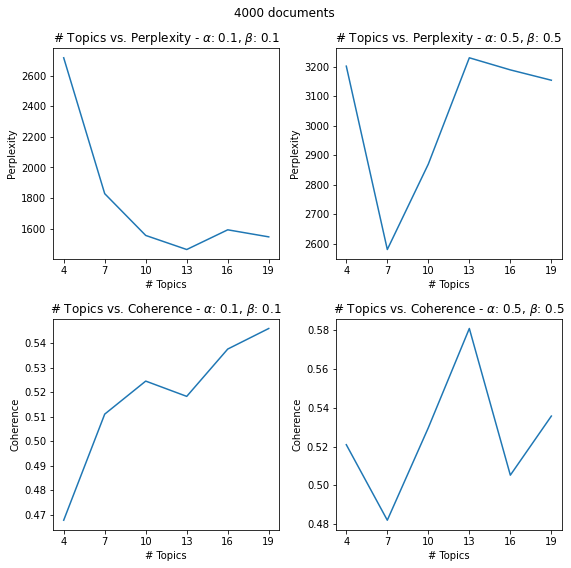

In [44]:
import matplotlib.pyplot as plt

df_results_4000 = pd.read_csv("results/resultset_n4000.csv")
df_results_4000.sort_values(by="K", ascending=True, inplace=True)

ab_groups = df_results_4000.groupby(by=["alpha", "beta"])

fig, axes = plt.subplots(nrows=2, ncols=len(ab_groups), figsize=(4*2, 4*len(ab_groups)))
axes = axes.flatten()

for i, ((a, b), data) in enumerate(ab_groups):   
    ax_idx = len(ab_groups)
    axes[i].plot(data["K"], data["perplexity"])
    axes[i].set_xlabel("# Topics")
    axes[i].set_ylabel("Perplexity")
    axes[i].set_title("# Topics vs. Perplexity - $\\alpha$: {}, $\\beta$: {}".format(a, b))
    axes[ax_idx + i].plot(data["K"], data["coherence"])
    axes[ax_idx + i].set_xlabel("# Topics")
    axes[ax_idx + i].set_ylabel("Coherence")
    axes[ax_idx + i].set_title("# Topics vs. Coherence - $\\alpha$: {}, $\\beta$: {}".format(a, b))

for ax in axes:
    ax.set_xticks(df_results_4000["K"].unique())

fig.suptitle("4000 documents")
plt.tight_layout()

fig.savefig("results/resultset_4000-TopicVariation.pdf")

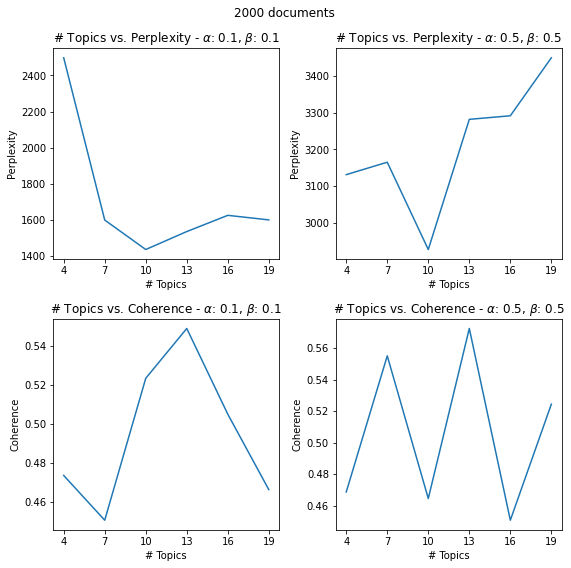

In [43]:
import matplotlib.pyplot as plt

df_results_2000 = pd.read_csv("results/resultset_n2000.csv")
df_results_2000.sort_values(by="K", ascending=True, inplace=True)

ab_groups = df_results_2000.groupby(by=["alpha", "beta"])

fig, axes = plt.subplots(nrows=2, ncols=len(ab_groups), figsize=(4*2, 4*len(ab_groups)))
axes = axes.flatten()

for i, ((a, b), data) in enumerate(ab_groups):   
    ax_idx = len(ab_groups)
    axes[i].plot(data["K"], data["perplexity"])
    axes[i].set_xlabel("# Topics")
    axes[i].set_ylabel("Perplexity")
    axes[i].set_title("# Topics vs. Perplexity - $\\alpha$: {}, $\\beta$: {}".format(a, b))
    axes[ax_idx + i].plot(data["K"], data["coherence"])
    axes[ax_idx + i].set_xlabel("# Topics")
    axes[ax_idx + i].set_ylabel("Coherence")
    axes[ax_idx + i].set_title("# Topics vs. Coherence - $\\alpha$: {}, $\\beta$: {}".format(a, b))

for ax in axes:
    ax.set_xticks(df_results_2000["K"].unique())

fig.suptitle("2000 documents")
plt.tight_layout()

fig.savefig("results/resultset_2000-TopicVariation.pdf")

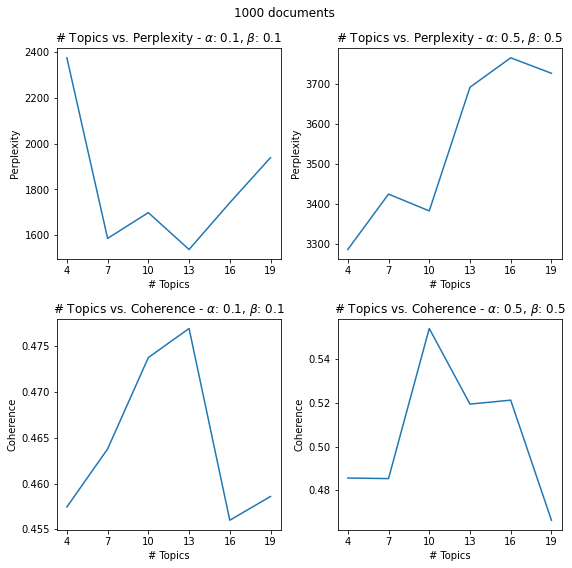

In [45]:
import matplotlib.pyplot as plt

df_results_1000 = pd.read_csv("results/resultset_n1000.csv")
df_results_1000.sort_values(by="K", ascending=True, inplace=True)

ab_groups = df_results_1000.groupby(by=["alpha", "beta"])

fig, axes = plt.subplots(nrows=2, ncols=len(ab_groups), figsize=(4*2, 4*len(ab_groups)))
axes = axes.flatten()

for i, ((a, b), data) in enumerate(ab_groups):   
    ax_idx = len(ab_groups)
    axes[i].plot(data["K"], data["perplexity"])
    axes[i].set_xlabel("# Topics")
    axes[i].set_ylabel("Perplexity")
    axes[i].set_title("# Topics vs. Perplexity - $\\alpha$: {}, $\\beta$: {}".format(a, b))
    axes[ax_idx + i].plot(data["K"], data["coherence"])
    axes[ax_idx + i].set_xlabel("# Topics")
    axes[ax_idx + i].set_ylabel("Coherence")
    axes[ax_idx + i].set_title("# Topics vs. Coherence - $\\alpha$: {}, $\\beta$: {}".format(a, b))

for ax in axes:
    ax.set_xticks(df_results_2000["K"].unique())

fig.suptitle("1000 documents")
plt.tight_layout()

fig.savefig("results/resultset_1000-TopicVariation.pdf")

In [ ]:
# MAX_IT = 10
# EPS = 0.001
# tf.executing_eagerly()
# optim = tf.keras.optimizers.Adam(1e-3)
# # B = ed.Dirichlet(concentration=tf.fill([K, V], 0.1), name="topics")
# # Z = ed.DirichletMultinomial(tf.convert_to_tensor(Ns), concentration=tf.fill([D, K], 0.1))
# alpha = np.copy(alpha_n).astype(np.float32)
# eta = np.copy(eta_n).astype(np.float32)

# beta = np.copy(beta_n).astype(np.float32)
# phi = [np.full((n, K), 1/K).astype(np.float32) for n in Ns]
# gamma = np.copy(gamma_n).astype(np.float32)
# lmbd = np.copy(lmbd_n).astype(np.float32)

# bb = None
# gg = None
# ww = None

# class Positive(tf.keras.constraints.Constraint):
#     def __call__(self, w):
#         return w * tf.cast(tf.math.greater(w, 0.), w.dtype)

# bb = []
# for it in trange(MAX_IT):
#     bb2 = []
#     gg2 = []
#     ww2 = []
#     print('before', gamma)
#     for d in range(D):
#         for n in range(Ns[d]):
#             for i in range(K):
#                 phi[d][n, i] = beta[i, data_enc.iloc[d][n]] * np.exp(digamma(gamma[d, i]) - digamma(np.sum(gamma[d])))
#         phi[d] /= np.sum(phi[d], axis=-1, keepdims=True) + 1e-5
        
#         for i in range(K):
#             gamma[d, i] = alpha[i] + np.sum(phi[d][:, i])
#     print('after', gamma)

#     lmbd = np.full((K, V), eta)
#     for i in range(K):
#         for j in range(V):
#             for d in range(D):
#                 mask = (data_enc.iloc[d] == j)
#                 lmbd[i, j] += np.sum(phi[d][:, i]*mask)
    
     
# #     if bb is None:
# #         bb = bb2
# #         gg = gg2
# #         ww = ww2
# #         break
                
#     alpha_t = tf.Variable(alpha, trainable=True, constraint=Positive())
#     gamma_t = tf.convert_to_tensor(gamma, dtype=tf.float32)
    
    
#     def f_x():
#         g_term = tf.math.reduce_sum(tf.expand_dims((alpha_t - 1), 0)*(tf.math.digamma(gamma_t) - 
#                                                    tf.math.digamma(tf.math.reduce_sum(gamma_t, axis=1, keepdims=True))), axis=1)
#         loss = -tf.math.reduce_sum(tf.math.lgamma(tf.math.reduce_sum(alpha_t)) - tf.math.reduce_sum(tf.math.lgamma(alpha_t)) + g_term)
#         return loss
    
#     for itt in range(10):
#         for i in range(K):
#             for itt1 in range(50):
#                 #with tf.GradientTape() as tape:
#                 optim.minimize(f_x, [alpha_t])
# #                 grads = tape.gradient(loss, opt_a)
# #                 optim.apply_gradients([(grads, opt_a)])
#                 alpha[i] = alpha_t.numpy()[i]
#                 np.nan_to_num(alpha, copy=False, nan=1e-5)
#                 alpha_t.assign(alpha)
#         print(alpha_t)
#     beta = (lmbd - eta) / (np.sum(lmbd - eta, axis=-1, keepdims=True) + 1e-5)
#     break
    
#     eta_t = tf.Variable(eta, trainable=True, constraint=Positive())
    
#     @tf.function
#     def f_eta():
#         loss = K*((eta_t-1)*(tf.math.digamma(eta_t) - tf.math.digamma(eta_t*V)) + tf.math.lgamma(eta_t*V) - V*tf.math.lgamma(eta))
#         return loss
    
#     for itt1 in range(50):
#         optim.minimize(f_eta, [eta_t])
#     eta = eta_t.numpy()

    